# EXPERIMENT 4: EXTRACTING ADDITONAL TRAIN/VALIDATE DATASET FROM PLOD-FILTERED
- **System 1:** Train solely on PLOD-CW
- **System 2:** Additional 1% of data from PLOD-Filtered combined with PLOD-CW.
- **System 3:** Additional 5% of data from PLOD-Filtered combined with PLOD-CW.

## Imports 

In [21]:
import nltk
import torch
import wandb
import multiprocessing
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric, concatenate_datasets, Sequence, Value
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import (
    AutoModel,
    AutoModelForTokenClassification,
    RobertaTokenizerFast,
    RobertaForTokenClassification,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from transformers.trainer_utils import EvalPrediction
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import random
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display, HTML
from seqeval.metrics import classification_report as seqeval_classification_report

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Load the Datasets
Here we load both the dataset, PLOD-CW and PLOD-Filtered

In [22]:
plod_filtered = load_dataset("surrey-nlp/PLOD-Filtered")

In [23]:
plod_cw = load_dataset("surrey-nlp/PLOD-CW")

We notice the PLOD-Filtered pos_tags and ner_tags are encoded. For concatenating both the datasets we need to convert one dataset to match the other. 
After studying the dataset, we can interpret the 'ner_tags' as follows:
- B-O (0): Tokens that are not part of an abbreviation or long-form.
- B-AC (1): Tokens that mark the beginning of an abbreviation/acronym.
- B-LF (3): Tokens that mark the beginning of a long form.
- I-LF (4): Tokens that are inside  a long form.

We notice the dataset doesn't contain 2 which basically is:
- I-AC (2): Tokens that are inside an abbreviation/acronym

Keeping this in mind we'll convert the 'pos_tags' and 'ner_tags' in our PLOD-CW accordinly.

## Encoding POS tags and NER tags

### Encoding POS Tags

In [29]:
# Create a label encoder
label_encoder = LabelEncoder()
all_pos_tags = [tag for sublist in plod_cw['train']['pos_tags'] for tag in sublist]

# Fit the label encoder on the 'pos_tags' feature of the training dataset
label_encoder.fit(all_pos_tags)

# Define a function to label encode the 'pos_tags' feature
def label_encode(example):
    example['pos_tags'] = label_encoder.transform(example['pos_tags'])
    return example

# Map the label encoding function to all datasets and splits
for split in ['train', 'validation', 'test']:
    plod_cw[split] = plod_cw[split].map(label_encode)

### Encoding NER Tags

In [30]:
label_encoding = {"B-O": 0, "B-AC": 1, "I-AC": 2, "B-LF": 3, "I-LF": 4} # Dictionary for label encoding
index_to_label = {index: label for label, index in label_encoding.items()}
label_list = list(label_encoding.keys())

# Function to convert IDs to labels
def convert_ids_to_labels(dataset):
    return {'ner_tags': [index_to_label[tag] for tag in dataset['ner_tags']]}

def convert_labels_to_ids(dataset):
    return {'ner_tags': [label_encoding[tag] for tag in dataset['ner_tags']]}

# Convert ner_tags feature in plod_cw to their ids
plod_filtered = plod_filtered.map(convert_ids_to_labels)

In [31]:
display_random_rows(plod_filtered['train'])

,tokens,ner_tags,id,pos_tags
0,"[CDS, :, clinical, disease, score, ;, CLP, :, caecal, ligation, and, puncture, ;, GC, :, geometric, center, ;, %, GE, :, percentage, of, gastric, emptying, ;, GI, :, gastrointestinal, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-LF, B-O]",48903,"[12, 13, 0, 8, 8, 13, 12, 13, 0, 8, 5, 8, 13, 12, 13, 0, 8, 13, 8, 8, 13, 8, 1, 0, 8, 13, 12, 13, 0, 13]"
1,"[SMO-1, can, bind, to, typical, SUMO, Interacting, Motifs, (, SIMs, ), .]","[B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O]",34257,"[8, 3, 16, 1, 0, 12, 16, 8, 13, 12, 13, 13]"
2,"[Mobile, health, (, mHealth, ), interventions, are, increasingly, deployed, to, facilitate, engagement, in, care, ,, retention, ,, and, adherence, to, treatment, in, HIV, programs, ., mHealth, systems, are, attractive, as, they, extend, the, reach, of, the, clinic, ,, have, efficiencies, that, can, support, overextended, healthcare, workers, ,, and, can, be, implemented, at, relatively, low, cost, .]","[B-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]",89292,"[8, 8, 13, 12, 13, 8, 3, 2, 16, 1, 16, 8, 1, 8, 13, 8, 13, 5, 8, 1, 8, 1, 12, 8, 13, 12, 8, 3, 0, 14, 11, 16, 6, 8, 1, 6, 8, 13, 16, 8, 11, 3, 16, 0, 8, 8, 13, 5, 3, 3, 16, 1, 2, 0, 8, 13]"
3,"[Patients, diagnosed, with, bacterial, meningitis, displayed, significantly, elevated, soluble, B7, -, H3, (, sB7-H3, ), in, the, circulation, and, cerebrospinal, fluid, (, CSF, ), ,, and, levels, of, sB7, in, these, patients, correlated, closely, with, the, intensity, of, their, infectious, inflammatory, process, in, the, -H3CNS, [, 22, ], .]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O]",1452,"[8, 16, 1, 0, 8, 16, 2, 16, 0, 8, 13, 8, 13, 12, 13, 1, 6, 8, 5, 0, 8, 13, 12, 13, 13, 5, 8, 1, 12, 1, 6, 8, 16, 2, 1, 6, 8, 1, 11, 0, 0, 8, 1, 6, 12, 13, 9, 13, 13]"
4,"[In, this, secondary, screen, ,, we, found, fat, body, -, specific, knock, -, down, of, purple, (, pr, ), also, enhances, feeding, in, adult, flies, .]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]",37042,"[1, 6, 0, 8, 13, 11, 16, 0, 8, 13, 0, 8, 13, 8, 1, 8, 13, 12, 13, 2, 16, 8, 1, 0, 8, 13]"


### Checking Feature Alignment

In [32]:
# Check the types of features in the plod_cw['train'] dataset
print("Features of plod_cw['train'] dataset:")
print(plod_cw['train'].features)

# Check the types of features in the train_subset dataset
print("\nFeatures of plod_filtered['train'] dataset:")
print(plod_filtered['train'].features)


Features of plod_cw['train'] dataset:
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

Features of plod_filtered['train'] dataset:
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'id': Value(dtype='string', id=None), 'pos_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [33]:
# Modify the feature type for pos_tags to int64 in PLOD-CW datasets
new_feature = Sequence(feature=Value(dtype='int64'))

# Cast the pos_tags column to the new feature type
plod_cw = plod_cw.cast_column('pos_tags', new_feature)

In [34]:
# Lets display the dataset to see the changes
display_random_rows(plod_cw['train'])

,tokens,pos_tags,ner_tags
0,"[Mice, that, need, to, be, perfused, with, PBS, and/or, 4, %, paraformaldehyde, (, PFA, ), prior, to, tissue, harvest, were, anesthetized, with, a, combination, of, ketamine, (, 20, mg, /, kg, body, weight, ), and, xylazine, (, 2, mg, /, kg, body, weight, ), .]","[7, 10, 15, 1, 3, 15, 1, 11, 4, 8, 7, 7, 12, 11, 12, 2, 1, 7, 7, 3, 15, 1, 5, 7, 1, 7, 12, 8, 7, 14, 7, 7, 7, 12, 4, 7, 12, 8, 7, 14, 7, 7, 7, 12, 12]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"
1,"[This, indicates, that, a, Chromosome, 4, bivalent, experiences, on, average, 1.76, CO, in, male, meiosis, ,, but, only, 1.05, CO, in, female, meiosis, (, M, /, F, ratio, 1.68, ), .]","[10, 15, 13, 5, 7, 8, 0, 15, 1, 0, 8, 11, 1, 0, 7, 12, 4, 2, 8, 11, 1, 0, 7, 12, 11, 14, 11, 7, 8, 12, 12]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-LF, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-LF, B-O, B-O, B-AC, B-O, B-AC, B-O, B-O, B-O, B-O]"
2,"[Within, the, first, week, after, surgery, ,, 7.7, ±, 0.6, %, of, dendritic, spines, were, eliminated, and, 8.1, ±, 0.5, %, were, formed, in, sham, mice, ,, whereas, 11.4, ±, 1.1, %, and, 11.9, ±, 1.1, %, of, dendritic, spines, were, eliminated, and, formed, in, SNI, mice, ,, respectively, .]","[1, 5, 0, 7, 1, 7, 12, 8, 14, 8, 7, 1, 0, 7, 3, 15, 4, 8, 14, 8, 7, 3, 15, 1, 0, 7, 12, 13, 8, 14, 8, 7, 4, 8, 14, 8, 7, 1, 0, 7, 3, 15, 4, 15, 1, 11, 7, 12, 2, 12]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O]"
3,"[IQR, :, interquartile, range, Similarly, ,, assessment, of, other, quantitative, variables, is, essential, in, pre-, and, post, -, MI, conditions, which, primarily, includes, ,, plasma, glucose, levels, ,, body, mass, index, (, BMI, ), ,, high, density, lipid, (, HDL, ), ,, low, density, lipid, (, LDL, ), and, triglycerides, levels, .]","[11, 12, 0, 7, 2, 12, 7, 1, 0, 0, 7, 3, 0, 1, 0, 4, 0, 0, 11, 7, 10, 2, 15, 12, 7, 7, 7, 12, 7, 7, 7, 12, 11, 12, 12, 0, 7, 7, 12, 11, 12, 12, 0, 7, 7, 12, 11, 12, 4, 7, 7, 12]","[B-AC, B-O, B-LF, I-LF, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O]"
4,"[BMI, ,, body, mass, index, ;, HR, ,, hazard, ratio, ;, SD, ,, standard, deviation, .]","[11, 12, 7, 7, 7, 12, 11, 12, 7, 7, 12, 11, 12, 0, 7, 12]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, B-O]"


## Extraction and Concatenation
Now that we have aligned the features in our dataset, lets move on to extracting data from PLOD-Filtered and concatenate with PLOD-CW.

Before extraction, I have to avoid duplication to ensure data integrity. For this I have to remove rows from PLOD-Filtered that are already present in PLOD-CW. For this, I decided to add tuple representation to each entry to ensure uniqueness. Further explanation on why I did so is explained in the report.

### Adding Tuple Representation

In [35]:
# Function to add tuple representation to each entry
def add_tuple_representation(example):
    if isinstance(example['tokens'], list):
        example['tokens_tuple'] = tuple(example['tokens'])
    return example

# Apply the function to the plod_filtered dataset
plod_filtered = plod_filtered.map(add_tuple_representation)

### Removing Duplicate Entries from PLOD-Filtered

In [36]:
# Collect tokens tuples from plod_cw
plod_cw_tuples = set()
for split in plod_cw.values():
    for example in split:
        if isinstance(example['tokens'], list):
            plod_cw_tuples.add(tuple(example['tokens']))

# Filter out duplicates based on the new tuple field
filtered_dataset = plod_filtered.filter(lambda example: 'tokens_tuple' in example and tuple(example['tokens']) not in plod_cw_tuples)

In [37]:
# Shuffle and save the dataset
filtered_dataset = filtered_dataset.shuffle(seed=42)
#filtered_dataset.save_to_disk('C:/Users/naima/OneDrive/Documents/CW-NLP/datasets/Filtered_PLOD')

### Function to Extract Subset

In [38]:
def extract_subset(dataset, subset_size, seed=42):
    subset = dataset.train_test_split(test_size=subset_size, seed=seed)['test']
    return subset

## Load RoBERTa Tokenizer and Model

In [39]:
# Load tokenizer
model_checkpoint = 'roberta-base'
tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)

In [40]:
# Load Model
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=5)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [42]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Function to Tokenize and Align Labels

In [43]:
# Function to tokenize the inputs
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, padding=True, is_split_into_words=True)
    labels = [] # Empty list to store labels for all tokenized inputs
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # Map tokens to their word ids
        previous_word_idx = None
        label_ids = []
        # Assign label to each token
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100) # Assigning -100 as ignore index for special tokens
            elif word_idx != previous_word_idx:
                # Start of a new word, assign label
                label_ids.append(label_encoding.get(label[word_idx]))
            else:
                # No increment needed, just append the label ID
                label_ids.append(label_encoding.get(label[word_idx]))
            previous_word_idx = word_idx
        labels.append(label_ids) # Append preprocessed labels for the input
    tokenized_inputs['labels'] = labels # Add labels in tokenized inputs
    return tokenized_inputs # Return tokenized input with labels

In [44]:
# Tokenizer returns the dataset in the form of a dictionary of lists (sentences). 
# we have to convert it into a list of dictionaries for training.
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

## Metric Computation Function

In [45]:
metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## Defining Loss Function

In [46]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing  # Initialize the smoothing factor

    def forward(self, input, target):
        # Create a mask for valid labels (labels not equal to -100)
        valid_labels_mask = target != -100

        # Apply mask to filter out invalid labels and logits
        target = target[valid_labels_mask]
        input = input[valid_labels_mask]

        # Ensure there are valid labels left after masking
        if len(target) == 0:
            return torch.tensor(0.0).to(input.device)  # Return 0 loss if no valid labels

        # Compute log probabilities
        log_prob = nn.functional.log_softmax(input, dim=-1)

        # Compute weights for label smoothing
        weight = input.new_ones(input.size(-1)) * self.smoothing / (input.size(-1) - 1.)
        weight = weight.repeat(input.size(0), 1)  # Repeat weight for each example in the batch
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))

        # Compute the loss
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

# Initialize the criterion with label smoothing factor
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

## Initializing a Custom Trainer

In [47]:
class CustomTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

## Setting up Training Arguments

In [48]:
# Define training arguments
epochs = 3
batch_size = 10
learning_rate = 2e-5

training_args = TrainingArguments(
    output_dir='./results', # Directory to save output files
    evaluation_strategy='steps', # Evaluating model every eval_step
    eval_steps=1000, # Number of steps to run evaluation
    save_total_limit = 3, # Max number of models to save
    learning_rate=learning_rate, # Learning rate for the optimizer
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs, # Number of training epochs
    weight_decay=0.01, # Weight decay for regularization
    save_steps=5000, # Saving model every 5k steps
    metric_for_best_model = 'f1', # Metric to evaluate the best model
    load_best_model_at_end=True # Load the best model post training
)

# System 1: Training only on PLOD-CW
Since I have already implemented this system in Experiment 2, I will use the same to compare the other systems to see if additonal instances improve the model performance.

Link to [Train only on PLOD-CW with Label Smoothing](EXPERIMENT-2.ipynb)

# System 2: 1% Additional Train/Validate from PLOD-Filtered + PLOD-CW

## Extraction and Concatenation

In [49]:
# Extract 1% of the training and validation split
train_subset = extract_subset(filtered_dataset['train'], 0.01)
validation_subset = extract_subset(filtered_dataset['validation'], 0.01)

# Concatenate the train_subset and validation_subset with the PLOD-CW train and val dataset
train_dataset_combined = concatenate_datasets([plod_cw['train'], train_subset])
val_dataset_combined = concatenate_datasets([plod_cw['validation'], validation_subset])

## Tokenizing the Concatenated Dataset

In [50]:
train_combined_tokenized = tokenize_and_align_labels(train_dataset_combined)
val_combined_tokenized = tokenize_and_align_labels(val_dataset_combined)

In [51]:
train_combined_tokenized=turn_dict_to_list_of_dict(train_combined_tokenized)
val_combined_tokenized=turn_dict_to_list_of_dict(val_combined_tokenized)

## Train the Model

In [52]:
# initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_combined_tokenized,
    eval_dataset=val_combined_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    loss_fn=criterion # Label Smoothing Loss Function
)


In [ ]:
# Train the model
trainer.train()

wandb: Currently logged in as: naima99rashid (university-of-surrey). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [ ]:
model.save_pretrained('C:/Users/naima/OneDrive/Documents/CW-NLP/roberta-base-model')
print("Model Saved.")

## Evaluating on Validation Set

In [39]:
evaluation_results = trainer.evaluate()

print('Evaluation Results:', evaluation_results)

Evaluation Results: {'eval_loss': 0.5681433081626892, 'eval_precision': 0.9523636363636364, 'eval_recall': 0.9447565060551404, 'eval_f1': 0.948544819557625, 'eval_accuracy': 0.9442232963700123, 'eval_runtime': 29.4916, 'eval_samples_per_second': 12.41, 'eval_steps_per_second': 1.255, 'epoch': 3.0}


## Obtain Predictions on PLOD-CW Test Set

In [40]:
plod_tokenized = plod_cw.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [62]:
# Prepare the test data for evaluation in the same format as the training data
predictions, labels, _ = trainer.predict(plod_tokenized['test'])
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens 
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test restuls
results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'AC': {'precision': 0.8917431192660551,
  'recall': 0.8694096601073346,
  'f1': 0.8804347826086957,
  'number': 559},
 'LF': {'precision': 0.7873015873015873,
  'recall': 0.8551724137931035,
  'f1': 0.8198347107438017,
  'number': 290},
 'O': {'precision': 0.9798193349990391,
  'recall': 0.9666287447857413,
  'f1': 0.9731793452324139,
  'number': 5274},
 'overall_precision': 0.9619000494804553,
 'overall_recall': 0.9524742773150416,
 'overall_f1': 0.9571639586410635,
 'overall_accuracy': 0.9534562211981567}

In [63]:
# Flatten the true_labels and true_predictions
true_labels_flat = [item for sublist in true_labels for item in sublist]
true_predictions_flat = [item for sublist in true_predictions for item in sublist]

In [64]:
# Obtaning the lengths of the original sequences
lengths_of_original_sequences = [len(seq) for seq in true_labels]

# Reshaping true_labels_flat and true_predictions_flat into lists of lists
true_labels_nested = []
true_predictions_nested = []

# Iterating over the lengths of the original sequences
idx = 0
for length in lengths_of_original_sequences:
    true_labels_nested.append(true_labels_flat[idx : idx + length])
    true_predictions_nested.append(true_predictions_flat[idx : idx + length])
    idx += length

## Generating Classification Report

In [65]:
# Compute classification report
report = seqeval_classification_report(true_labels_nested, true_predictions_nested)

# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          AC       0.89      0.87      0.88       559
          LF       0.79      0.86      0.82       290
           O       0.98      0.97      0.97      5274

   micro avg       0.96      0.95      0.96      6123
   macro avg       0.89      0.90      0.89      6123
weighted avg       0.96      0.95      0.96      6123



## Error Analysis

### Plotting Confusion Matrix

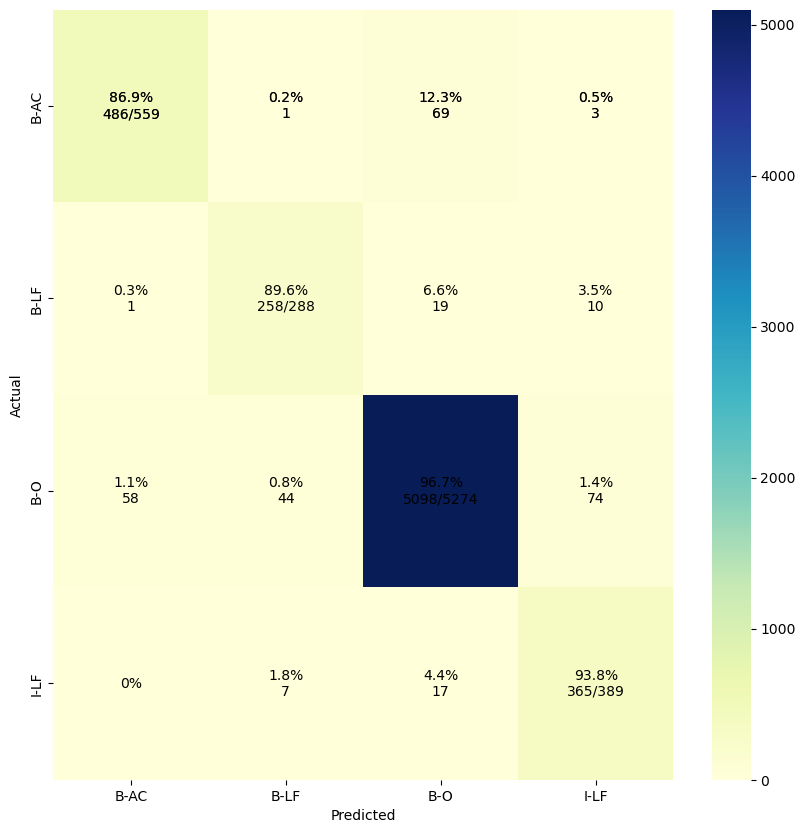

In [66]:
def plot_cm(y_true, y_pred, color, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0%'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= color, annot=annot, fmt='', ax=ax)

    # Loop through all cells to ensure each one is annotated
    for i in range(nrows):
        for j in range(ncols):
            plt.text(j+0.5, i+0.5, annot[i, j], ha='center', va='center', color='black')

    #plt.savefig('Exp1-cm.png')
    plt.show()

plot_cm(true_labels_flat, true_predictions_flat, color="YlGnBu")

### Calculating Error Types

In [67]:
def calculate_error_types(true_predictions_flat, true_labels_flat):
    # Error types dictionary
    error_types = {
        'False Positive': {class_label: 0 for class_label in ['B-O', 'B-AC', 'I-LF', 'B-LF']},
        'False Negative': {class_label: 0 for class_label in ['B-O', 'B-AC', 'I-LF', 'B-LF']},
        'True Positive': {class_label: 0 for class_label in ['B-O', 'B-AC', 'I-LF', 'B-LF']},
        'True Negative': {class_label: 0 for class_label in ['B-O', 'B-AC', 'I-LF', 'B-LF']}
    }

    # Iterate over each prediction and true label pair
    for pred, true_label in zip(true_predictions_flat, true_labels_flat):
        # Iterate over each tag
        for class_label in ['B-O', 'B-AC', 'I-LF', 'B-LF']:
            if pred == class_label and true_label == class_label:
                error_types['True Positive'][class_label] += 1
            elif pred == class_label and true_label != class_label:
                error_types['False Positive'][class_label] += 1
            elif pred != class_label and true_label == class_label:
                error_types['False Negative'][class_label] += 1
            elif pred != class_label and true_label != class_label:
                error_types['True Negative'][class_label] += 1

    return error_types


def print_error_types(error_types):
    for error_type, class_counts in error_types.items():
        print(error_type)
        for class_label, count in class_counts.items():
            print(f"  {class_label}: {count}")


error_types = calculate_error_types(true_predictions_flat, true_labels_flat)
print_error_types(error_types)

False Positive
  B-O: 105
  B-AC: 59
  I-LF: 87
  B-LF: 52
False Negative
  B-O: 176
  B-AC: 73
  I-LF: 24
  B-LF: 30
True Positive
  B-O: 5098
  B-AC: 486
  I-LF: 365
  B-LF: 258
True Negative
  B-O: 1131
  B-AC: 5892
  I-LF: 6034
  B-LF: 6170


### Visualizing Error Distribution

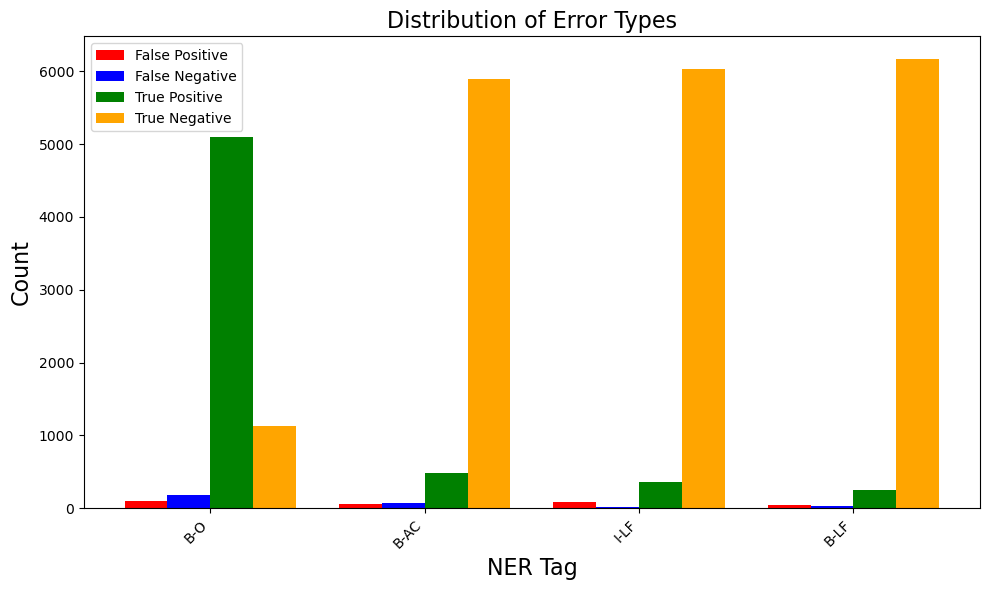

In [68]:
def visualize_error_types(error_types):
    # Extract error types
    false_positives = {k: v for k, v in error_types['False Positive'].items()}
    false_negatives = {k: v for k, v in error_types['False Negative'].items()}
    true_positives = {k: v for k, v in error_types['True Positive'].items()}
    true_negatives = {k: v for k, v in error_types['True Negative'].items()}

    # Get class labels
    class_labels = list(false_positives.keys())

    # Visualize error types with grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(class_labels))

    # Plot bars for each error type
    bars1 = ax.bar(index, false_positives.values(), bar_width, label='False Positive', color='red')
    bars2 = ax.bar(index + bar_width, false_negatives.values(), bar_width, label='False Negative', color='blue')
    bars3 = ax.bar(index + 2 * bar_width, true_positives.values(), bar_width, label='True Positive', color='green')
    bars4 = ax.bar(index + 3 * bar_width, true_negatives.values(), bar_width, label='True Negative', color='orange')

    ax.set_xlabel('NER Tag', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Distribution of Error Types', fontsize=16)
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(class_labels, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

visualize_error_types(error_types)